# User's metadata analysis 

This notebook helps to retrieve, analyse and visualize user's metadata for all of the users.

In particular, this notebook contains :
* reusable functions for any users in Wikipedia
* plots visualization to see patterns
* analysis of the results to understand the impact of the metadata of a user and his editing behaviour.

The final goal of this notebook is to build a solid dataframe of users matadata that can be added to the big dataframe for creating a training set to build a LLM Classification.

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import calendar
from tqdm import tqdm

In [8]:
df = pd.read_csv('../../datas/final/full_db_preprocess.csv')

In [102]:
print(df["user"].nunique(), "unique users found")
print()
print(df["user"].value_counts().head(11))  # Top users by edit count 
users_list = df['user'].unique().tolist() # List of all the users that has made at least one edit in the df.

# Identify the top 10 users that made the more edits
top_users = (
    df
    .groupby(["user"])
    .size()
    .sort_values(ascending=False)
    .head(11)
    .index
)
top10_users_list = list(top_users) # List of the top 10 users that have made the most edits in the df.

df_ip = df[df['user_type'] == 'Anonymous (IP)']
df_registered = df[df['user_type'] == 'Registered']
df_bot = df[df['user_type'] == 'Bot']

ip_users_list = df_ip['user'].unique().tolist()
top_ip_users = (
    df_ip
    .groupby(["user"])
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
)
top10_ip_users_list = list(top_ip_users)
registered_users_list = df_registered['user'].unique().tolist()
bot_users_list = df_bot['user'].unique().tolist()


19769 unique users found

user
Yulia Romero           1377
Aleksandr Grigoryev    1287
RGloucester            1157
Lvivske                1038
LSGH                    532
AnomieBOT               494
Seryo93                 434
JASpencer               423
Mibelz                  387
Iryna Harpy             384
Irpen                   379
Name: count, dtype: int64


In [18]:
URL = "https://en.wikipedia.org/w/api.php"
HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)"
}

def get_user_metadata(username, max_retries=3, backoff=1.0):
    session = requests.Session()
    session.headers.update(HEADERS)

    params = {
        "action": "query",
        "list": "users",
        "ususers": username,
        "usprop": "blockinfo|groups|editcount|registration|emailable|gender",
        "format": "json"
    }

    for attempt in range(max_retries):
        try:
            response = session.get(url=URL, params=params, timeout=10)

            if response.status_code != 200:
                return {"user": username, "error": f"HTTP {response.status_code}"}

            try:
                data = response.json()
            except ValueError:
                return {"user": username, "error": "Invalid JSON response"}

            if "query" in data and "users" in data["query"]:
                return data["query"]["users"][0]
            else:
                return {"user": username, "error": "Missing 'users' in response"}

        except Exception as e:
            time.sleep(backoff * (2 ** attempt))  # exponential backoff

    return {"user": username, "error": f"Failed after {max_retries} attempts"}

df_list = []

for user in tqdm(registered_users_list):
    dico = get_user_metadata(user)
    df_metadata = pd.DataFrame([dico])
    df_list.append(df_metadata)

users_metadata = pd.concat(df_list, ignore_index=True)

100%|███████████████████████████████████████| 9095/9095 [43:37<00:00,  3.47it/s]


## Metrics 

Different metrics are use to analyse how an user is editing :
- account age
- burstiness
- active days and months
- gender
- user group
- edit count

In [45]:
def preprocess_usercontribs(df):
    """
    Ensures timestamp column is a proper datetime and sorts values.
    """
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    return df.sort_values(["username", "timestamp"])

def compute_edit_frequency(df):
    """
    Computes edit frequency metrics for each user:
    - total edits
    - active days
    - edits per day
    - edits per month
    - edits per active day (engagement intensity)
    
    Returns a DataFrame indexed by username.
    """
    df = preprocess_usercontribs(df)
    
    freq = (
        df.groupby("username")
          .agg(
              total_edits=("revid", "count"),
              first_edit=("timestamp", "min"),
              last_edit=("timestamp", "max")
          )
    )
    
    # Convert to metrics
    freq["active_days"] = (freq["last_edit"] - freq["first_edit"]).dt.days + 1
    freq["active_months"] = freq["active_days"] / 30.44  # precise month equivalence
    freq["edits_per_day"] = freq["total_edits"] / freq["active_days"]
    freq["edits_per_month"] = freq["total_edits"] / (freq["active_days"] / 30)
    freq["edits_per_active_day"] = freq["total_edits"] / freq["active_days"]
    
    
    return freq

def compute_burstiness_for_user(timestamps):
    """
    Computes burstiness B for a single user:
    
         B = (σ - μ) / (σ + μ)
    
    where μ = mean inter-event time, σ = std dev of inter-event time.
    
    Range:
    - B → -1 : perfectly regular
    - B = 0  : Poisson-like random
    - B → 1  : very bursty
    
    Returns None if insufficient data.
    """
    if len(timestamps) < 3: # means we have insufficient data
        return None
    
    deltas = np.diff(timestamps.astype("int64") // 1e9)  # seconds
    
    mu = deltas.mean()
    sigma = deltas.std()
    
    if (mu + sigma) == 0:
        return None
    return (sigma - mu) / (sigma + mu)

def compute_burstiness(df):
    """
    Computes burstiness for each user.
    Returns a DataFrame: username, burstiness.
    """
    df = preprocess_usercontribs(df)

    burstiness_list = []
    for user, group in df.groupby("username"):
        timestamps = group["timestamp"].values
        B = compute_burstiness_for_user(timestamps)
        burstiness_list.append({"username": user, "burstiness": B})
    
    return pd.DataFrame(burstiness_list)

def compute_temporal_patterns(df):
    """
    Extracts temporal patterns for each user:
    - most_active_hour
    - most_active_weekday
    - night_edit_ratio (edits 00:00–06:00)
    - weekend_edit_ratio
    
    Returns DataFrame: one row per user.
    """
    df = preprocess_usercontribs(df)

    df["hour"] = df["timestamp"].dt.hour
    df["weekday"] = df["timestamp"].dt.weekday  # 0=Monday
    df["is_weekend"] = df["weekday"] >= 5

    results = (
        df.groupby("username")
          .agg(
              most_active_hour=("hour", lambda x: x.value_counts().idxmax()),
              most_active_weekday=("weekday", lambda x: x.value_counts().idxmax()),
              weekend_edit_ratio=("is_weekend", "mean")
          )
    )
    
    return results

def compute_user_activity_profile(df):
    """
    Combines all activity-related metrics into a single profiling table:
    - edit frequency
    - burstiness
    - temporal patterns
    """
    freq = compute_edit_frequency(df)
    burst = compute_burstiness(df)
    patterns = compute_temporal_patterns(df)

    full = (
        freq
        .merge(burst, on="username", how="left")
        .merge(patterns, on="username", how="left")
    )

    return full

import pandas as pd

def compute_account_age(metadata_dataframe, registration_col="registration", output_col="account_age_years"):
    """
    Compute the account age (in years) for each user given a metadata dataframe.
    """

    df = metadata_dataframe.copy()

    # Convert registration to datetime
    df[registration_col] = pd.to_datetime(df[registration_col], errors="coerce", utc=True)

    # Compute age in years
    df[output_col] = (pd.Timestamp.utcnow() - df[registration_col]).dt.total_seconds() / (365.25 * 24 * 3600)

    return df

## Plots

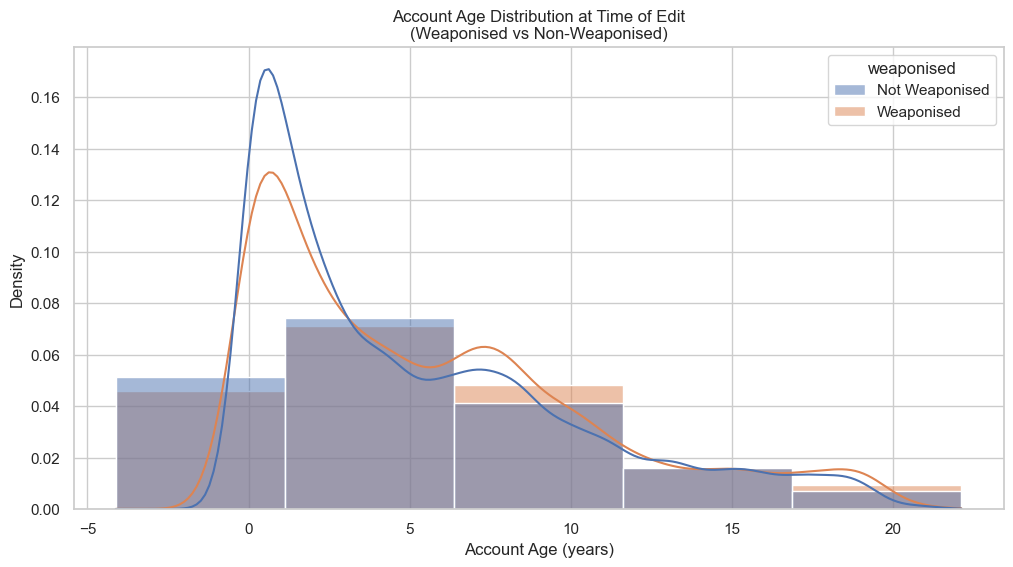

In [135]:
def match_age_with_df(dataframe, user_metadata_dataframe):

    df = dataframe.copy()

    # Ensure datetime columns are parsed correctly
    df["date"] = pd.to_datetime(df["date"], utc=True, errors="coerce")
    user_metadata_dataframe["registration"] = pd.to_datetime(user_metadata_dataframe["registration"], utc=True, errors="coerce")

    # Merge on user
    merged = df.merge(
        user_metadata_dataframe[["user", "registration"]],
        on="user",
        how="left"
    )

    # Compute account age at time of edit
    merged["account_age_days"] = (merged["date"] - merged["registration"]).dt.total_seconds() / 86400
    merged["account_age_years"] = merged["account_age_days"] / 365.25

    return merged

def plot_weap_vs_account_age(dataframe, user_metadata_dataframe):

    merged = match_age_with_df(dataframe, user_metadata_dataframe)

    plt.figure(figsize=(12, 6))
    sns.histplot(
        data=merged,
        x="account_age_years",
        hue="weaponised",
        bins=5,
        kde=True,
        stat="density",
        common_norm=False
    )
    plt.title("Account Age Distribution at Time of Edit\n(Weaponised vs Non-Weaponised)")
    plt.xlabel("Account Age (years)")
    plt.ylabel("Density")
    plt.show()

    return merged

df_test = plot_weap_vs_account_age(df, users_metadata)

In [105]:
ip_top_user_contribs_df = pd.read_csv('../../datas/interim/All Users Analysis/ip_user_contribs_df.csv')
ip_top_user_contribs_df['user'].unique()

array(['94.178.235.125', '77.252.47.155', '124.190.40.8',
       '212.137.36.230', '24.183.100.38', '61.102.45.248',
       '174.3.111.148', '172.202.173.230', '217.118.81.21',
       '217.118.81.18'], dtype=object)

In [115]:
df_top10_ip_contribs.to_csv('../../datas/interim/Full Database/df_top10_ip_contribs.csv', index=False)

In [98]:
def top10_weap_vs_not(dataframe, list_of_user, wanna_save=False):

    df = dataframe.copy()

    df["year"] = pd.to_datetime(df["date"], errors="coerce").dt.year

    # just a subset of data for now. subset of df but with only the edits made by the top_users.
    df_top = df[df["user"].isin(list_of_user)]
    
    # count edits per (user, year, weaponised)
    grouped = (
        df_top.groupby(["user", "year", "weaponised"])
        .size()
        .reset_index(name="count")
    )
    
    # Ensure seaborn style
    custom_palette = {
        "Weaponised": "#ed2939",      # red
        "Not Weaponised": "#1e90ff"   # blue
    }
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(12, 6))
    
    # Create the barplot
    g = sns.FacetGrid(grouped, col="user", col_wrap=2, height=3.5, sharey=False, sharex=False)
    g.map_dataframe(sns.barplot, x="year", y="count", hue="weaponised", palette=custom_palette, errorbar=None)
    g.add_legend(title="Edit Type")
    
    g.set_titles("{col_name}")
    g.set_axis_labels("Year", "Number of Edits")
    
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Weaponised vs Non-Weaponised Edits per Year — Top 10 Users")
    
    for ax in g.axes.flatten():
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
    
    plt.tight_layout()
    fig_title = 'Weaponised vs Non-Weaponised Edits per Year — Top 10 IP Users'
    plt.xticks(rotation=45, ha='right')
    if wanna_save:
        plt.savefig(f"../../plots/Full Database/{fig_title}.png", dpi=300, bbox_inches='tight')
    plt.show()


    
ukraine_keywords_small = [
    "ukraine", "ukrainian", "kyiv", "kiev", "crimea", "crimean", "kuban", "donbas", "donetsk", "luhansk",
    "maidan", "yanukovych", "yushchenko", "zelenskyy", "poroshenko", "catherine", "bukovina", "bessarabia", "eastern",
    "euromaidan", "dnipro", "odessa", "sevastopol", "putin", "rus'", "russia", "russian", "moscow", "kremlin", "soviet"
    ]

ukraine_keywords_large = [
    # core country and people
    "ukraine", "ukrainian", "kyiv", "kiev", "crimea", "crimean", "kuban", "donbas", "donetsk", "luhansk",
    "maidan", "yanukovych", "yushchenko", "zelenskyy", "poroshenko", "catherine", "bukovina", "bessarabia",
    "eastern", "euromaidan", "dnipro", "odessa", "sevastopol", "putin", "rus'", "russia", "russian", "moscow",
    "kremlin", "soviet",

    # politics & government
    "verkhovna rada", "president", "prime minister", "parliament", "government", "cabinet", "federation",
    "referendum", "annexation", "independence", "revolution", "reforms", "corruption", "sanctions",
    "occupation", "treaty", "agreement", "ceasefire", "negotiations", "elections", "coup", "unification",

    # geography & regions
    "zaporizhzhia", "mariupol", "kharkiv", "kherson", "mykolaiv", "chernihiv", "sumy", "poltava", "vinnytsia",
    "lviv", "ivano-frankivsk", "ternopil", "lutsk", "uzhhorod", "dnipropetrovsk", "donetsk oblast",
    "luhansk oblast", "transcarpathia", "prykarpattia", "galicia", "novorossiya", "black sea", "azov sea",

    # historical references
    "kyivan rus", "tsar", "imperial", "empire", "ussr", "communist", "lenin", "stalin", "bolshevik",
    "cold war", "perestroika", "glasnost", "collapse", "partition", "catherine the great", "brezhnev",
    "chernobyl", "orange revolution", "revolution of dignity", "holodomor", "soviet union",

    # war and military
    "invasion", "occupation", "annexed", "frontline", "offensive", "defense", "army", "forces", "military",
    "russian troops", "ukrainian forces", "separatist", "rebels", "paramilitary", "nato", "eu", "un", "war",
    "conflict", "shelling", "bombing", "airstrike", "occupation forces", "mobilization", "martial law",

    # culture, identity & language
    "language", "identity", "heritage", "culture", "orthodox", "church", "patriarch", "ukrainian language",
    "russian language", "minority", "bilingual", "autonomy", "nationalism", "independence day", "flag",
    "anthem", "symbol", "national identity", "sovereignty",

    # current / modern references
    "donbas war", "russian invasion", "ukrainian front", "crimea bridge", "moskva cruiser", "ukrainian army",
    "russian army", "zelensky", "kremlin propaganda", "occupation administration", "territorial defense",
    "european union", "eu membership", "nato membership", "nato expansion", "eu sanctions", "ukraine war",
    "full-scale invasion", "special military operation", "mobilisation", "referendum in crimea",

    # other
    "gas pipeline", "north stream", "energy crisis", "grain corridor", "black sea fleet", "peace talks",
    "donetsk people's republic", "luhansk people's republic", "kyiv oblast", "liberation", "resistance",
    "occupation zone", "ukrainian refugees", "mariupol steel plant", "azovstal", "bucha", "irpin", "kharkiv offensive"
    ]

def is_ukraine_related(title):
    if not isinstance(title, str):
        return False
    title_lower = title.lower()
    return any(kw in title_lower for kw in ukraine_keywords_small)

def plot_ukraine_related_article(contrib_dataframe, wanna_save=False):
    
    contrib_dataframe["ukraine_related"] = contrib_dataframe["title"].apply(is_ukraine_related)
    
    user_distribution = (
        contrib_dataframe
        .groupby(["username", "ukraine_related"])
        .size()
        .reset_index(name="count")
    )
    
    # Convert to percentages
    user_distribution["percentage"] = (
        user_distribution.groupby("username")["count"].transform(lambda x: 100 * x / x.sum())
    )
    
    sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})
    
    # Define a clear color palette (yellow = Ukraine-related, grey = not related)
    palette = {True: "#fed000", False: "#adb5bd"}
    
    ax = sns.barplot(
        data=user_distribution,
        x="username",
        y="percentage",
        hue="ukraine_related",
        palette=palette
    )
    
    plt.title("Proportion of every Wikipedia Edits per User on Small Ukraine-related Articles", fontsize=14, pad=15)
    plt.xlabel("Username", fontsize=12)
    plt.ylabel("Percentage of Edits", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    
    # Fix legend: ensure correct order and labels
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ["Ukraine-related", "Not Ukraine-related"] if labels[0] == "True" else ["Not Ukraine-related", "Ukraine-related"]
    plt.legend(handles=handles, labels=new_labels, title="Article Type", loc="upper right")
    fig_title = "Proportion of every Wikipedia Edits per IP User on Small Ukraine-related Articles"
    if wanna_save:
        plt.savefig(f"../../plots/Full Database/{fig_title}_small.png", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

In [131]:
#plot_ukraine_related_article(df_top10_ip_contribs, True)

In [130]:
#top10_weap_vs_not(df, top10_ip_users_list, True)

In [128]:
def plot_namespace_vs_user_type(registered_df, ip_df, wanna_save=False):

    # --- Aggregate counts ---
    reg_counts = (
        registered_df.groupby("ns")
        .size()
        .reset_index(name="count")
        .sort_values("ns")
    )

    reg_total = reg_counts["count"].sum()
    reg_counts["percentage"] = (reg_counts["count"] / reg_total * 100).round(2)


    ip_counts = (
        ip_df.groupby("ns")
        .size()
        .reset_index(name="count")
        .sort_values("ns")
    )

    ip_total = ip_counts["count"].sum()
    ip_counts["percentage"] = (ip_counts["count"] / ip_total * 100).round(2)

    # --- Plot Registered Users ---
    plt.figure(figsize=(10, 5))
    plt.bar(reg_counts["ns"].astype(str), reg_counts["count"])
    plt.title("Namespace Distribution for Registered Users")
    plt.xlabel("Namespace")
    plt.ylabel("Number of Edits")
    plt.xticks(rotation=45)

    if wanna_save:
        plt.tight_layout()
        plt.savefig("registered_namespace_distribution.png", dpi=300)
        print("Saved: registered_namespace_distribution.png")

    plt.show()

    # --- Plot IP Users ---
    plt.figure(figsize=(10, 5))
    plt.bar(ip_counts["ns"].astype(str), ip_counts["count"])
    plt.title("Namespace Distribution for IP Users")
    plt.xlabel("Namespace")
    plt.ylabel("Number of Edits")
    plt.xticks(rotation=45)

    if wanna_save:
        plt.tight_layout()
        plt.savefig("ip_namespace_distribution.png", dpi=300)
        print("Saved: ip_namespace_distribution.png")

    plt.show()

    return reg_counts, ip_counts

In [137]:
df_test[df_test['account_age_years'] <0]

,initial_version,changed_version,comment,user,date,llm_output,weaponised,article,user_type,registration,account_age_days,account_age_years
5313,<center>[[Image:Ukraine_flag_large.png]]</cent...,"--- \n+++ \n@@ -1,4 +1,4 @@\n [[Image:Ukraine_...",NaN,Template namespace initialisation script,2004-06-04 05:07:34+00:00,"Changed the template from ""{{msg:nationalflags...",Not Weaponised,Flag of Ukraine,Registered,2006-04-10 21:52:48+00:00,-675.698079,-1.849961
9136,Bessarabia is a region located in Eastern [[Eu...,"--- \n+++ \n@@ -12,7 +12,7 @@\n \n When the Mo...",NaN,Template namespace initialisation script,2004-06-04 07:18:53+00:00,"Changed the formatting of a template from ""{{m...",Not Weaponised,Bessarabia,Registered,2006-04-10 21:52:48+00:00,-675.606887,-1.849711
14657,The war between Germany and the Soviet Union d...,"--- \n+++ \n@@ -62,7 +62,7 @@\n ==External lin...",NaN,Template namespace initialisation script,2004-06-04 11:05:50+00:00,"Changed the formatting of a template from ""{{m...",Not Weaponised,Eastern Front (World War II),Registered,2006-04-10 21:52:48+00:00,-675.449282,-1.849279
25173,"ALEXANDER II. (1818-1881), emperor of Russia, ...",No changes,Automated conversion,Conversion script,2002-02-25 15:51:15+00:00,No changes made. \n\nWeaponised: Not Weaponise...,Weaponised,Alexander II of Russia,Registered,2006-04-09 08:05:49+00:00,-1503.676782,-4.116843
25247,"ALEXANDER II. (1818-1881), emperor of Russia, ...","--- \n+++ \n@@ -71,6 +71,6 @@\n </table>\n </c...",NaN,Template namespace initialisation script,2004-06-03 16:05:59+00:00,"Changed the template from ""{{msg:1911}}"" to ""{...",Not Weaponised,Alexander II of Russia,Registered,2006-04-10 21:52:48+00:00,-676.240845,-1.851447
28220,"<b>Military branches:</b>\r\nArmy, Navy, Air F...",Initial revision,Automated conversion,Conversion script,2002-02-25 15:43:11+00:00,"Changed the article to ""Initial revision"".\n\n...",Not Weaponised,Armed Forces of Ukraine,Registered,2006-04-09 08:05:49+00:00,-1503.682384,-4.116858
32622,"<b>Population:</b>\r\n49,153,027 (July 2000 es...",Initial revision,Automated conversion,Conversion script,2002-02-25 15:43:11+00:00,"Added ""Initial revision"".\n\nNot Weaponised – ...",Not Weaponised,Demographics of Ukraine,Registered,2006-04-09 08:05:49+00:00,-1503.682384,-4.116858
34631,<b>Disputes - international:</b>\r\n\ndispute ...,"--- \n+++ \n@@ -1,8 +1,6 @@\n <b>Disputes - in...",Automated conversion,Conversion script,2002-02-25 15:51:15+00:00,**Change Description:** Added information abou...,Weaponised,Foreign relations of Ukraine,Registered,2006-04-09 08:05:49+00:00,-1503.676782,-4.116843
35355,"<b>Economy - overview:</b>\r\nAfter Russia, th...",Initial revision,Automated conversion,Conversion script,2002-02-25 15:43:11+00:00,"Added ""Initial revision"".\n\nNot Weaponised – ...",Not Weaponised,Economy of Ukraine,Registered,2006-04-09 08:05:49+00:00,-1503.682384,-4.116858
58703,"Bukovina (or Bucovina, in [[Romanian Language|...","--- \n+++ \n@@ -15,7 +15,7 @@\n Most of the hi...",NaN,Template namespace initialisation script,2004-06-04 07:18:55+00:00,"Changed the formatting of a template from ""{{m...",Not Weaponised,Bukovina,Registered,2006-04-10 21:52:48+00:00,-675.606863,-1.849711
